## Exploring Flight Delays: A Data Modeling and Analysis Approach for Predicting Causes for Delays in Airline On-time Data

## Names

* Aditya Tomar
* Shay Samat
* Akhil Vasanth


# Preprocessing

In [ ]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
csv_files = []
years = [2018, 2019, 2022]
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

for year in years:
    for month in months:
        csv_file = "data/{:02d}_{}.csv".format(int(month), year)
        csv_files.append(csv_file)

dfs = []

for csv_file in csv_files:
    df = pd.read_csv(csv_file, low_memory=False)
    dfs.append(df)

flights = pd.concat(dfs, ignore_index=True)
flights.head()


,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST_CITY_NAME,DEST_STATE_ABR,DEP_DELAY_NEW,ARR_DELAY_NEW,ACTUAL_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,ORIGIN_STATE_NM,DEST_STATE_NM
0,1/1/2018 12:00:00 AM,9E,"Albany, GA",GA,"Atlanta, GA",GA,0.0,0.0,54.0,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1/1/2018 12:00:00 AM,9E,"Albany, GA",GA,"Atlanta, GA",GA,0.0,0.0,55.0,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1/1/2018 12:00:00 AM,9E,"Alexandria, LA",LA,"Atlanta, GA",GA,0.0,0.0,92.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1/1/2018 12:00:00 AM,9E,"Alexandria, LA",LA,"Atlanta, GA",GA,39.0,23.0,89.0,500.0,0.0,0.0,0.0,0.0,23.0,NaN,NaN
4,1/1/2018 12:00:00 AM,9E,"Appleton, WI",WI,"Minneapolis, MN",MN,0.0,0.0,65.0,236.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# dropping columns/features we aren't using
flights = flights.drop(["ORIGIN_STATE_ABR", "DEST_STATE_ABR","ORIGIN_STATE_NM","DEST_STATE_NM"], axis=1)


In [ ]:
#creating a month feature and year feature
flights['MONTH'] = [int(row.split('/')[0]) for row in flights['FL_DATE']]
flights['YEAR'] = [int(row.split('/')[2].split(' ')[0]) for row in flights['FL_DATE']]


In [ ]:
delay_columns = [col for col in flights.columns if "DELAY" in col]
flights[delay_columns] = flights[delay_columns].fillna(0)

In [ ]:
#creating the TOTAL_DELAY feature, the sum of arrival and departure delay
flights['TOTAL_DELAY'] = flights['ARR_DELAY_NEW'] + flights['DEP_DELAY_NEW']


In [ ]:
#create the DELAY_STATUS variable, which we will use as our class labels for each sample

delay_status = ['1' if (row > 0) else '0' for row in flights['TOTAL_DELAY']]
flights['DELAY_STATUS'] = delay_status


In [ ]:
#drop samples with missing/NaN values
flights = flights.dropna()

# Get the top 20 most common cities in 'ORIGIN_CITY_NAME'
top_origin_cities = flights['ORIGIN_CITY_NAME'].value_counts().nlargest(25).index

# Get the top 20 most common cities in 'DEST_CITY_NAME'
top_dest_cities = flights['DEST_CITY_NAME'].value_counts().nlargest(25).index

# Filter the DataFrame to include only the data for the top origin cities and top destination cities
filtered_data = flights[(flights['ORIGIN_CITY_NAME'].isin(top_origin_cities)) & (flights['DEST_CITY_NAME'].isin(top_dest_cities))]



In [ ]:
#random sample 50,000 datapoints
filtered_data = filtered_data.sample(n=50000, replace = False, random_state = 42)



In [ ]:
#One hot Encoding of Categorical Data

# Perform one-hot encoding for 'ORIGIN_CITY_NAME' with the top origin cities
origin_city_encoded = pd.get_dummies(filtered_data['ORIGIN_CITY_NAME'], prefix='OriginCity')

# Perform one-hot encoding for 'DEST_CITY_NAME' with the top destination cities
dest_city_encoded = pd.get_dummies(filtered_data['DEST_CITY_NAME'], prefix='DestCity')

# Perform one-hot encoding for 'OP_UNIQUE_CARRIER'
carrier_encoded = pd.get_dummies(filtered_data['OP_UNIQUE_CARRIER'], prefix='Carrier')

# Perform one-hot encoding for 'MONTH'
month_encoded = pd.get_dummies(filtered_data['MONTH'], prefix='Month')

# Perform one-hot encoding for 'YEAR'
year_encoded = pd.get_dummies(filtered_data['YEAR'], prefix='YEAR')

# Concatenate the one-hot encoded columns with the original DataFrame
encoded_data = pd.concat([filtered_data, origin_city_encoded, dest_city_encoded, carrier_encoded, month_encoded,
                           year_encoded], axis=1)

# Drop the original categorical columns from the encoded DataFrame
encoded_data = encoded_data.drop(['ORIGIN_CITY_NAME', 'DEST_CITY_NAME', 'OP_UNIQUE_CARRIER'], axis=1)
delay_columns = [col for col in flights.columns if "DELAY" in col]
delay_columns.remove('DELAY_STATUS')
encoded_data = encoded_data.drop(columns=delay_columns, axis=1)
encoded_data = encoded_data.drop(columns=['FL_DATE', 'ACTUAL_ELAPSED_TIME', 'MONTH', 'YEAR'])


# Scale the data

encoded_data.columns

Index(['DISTANCE', 'DELAY_STATUS', 'OriginCity_Atlanta, GA',
       'OriginCity_Baltimore, MD', 'OriginCity_Boston, MA',
       'OriginCity_Charlotte, NC', 'OriginCity_Chicago, IL',
       'OriginCity_Dallas/Fort Worth, TX', 'OriginCity_Denver, CO',
       'OriginCity_Detroit, MI', 'OriginCity_Fort Lauderdale, FL',
       'OriginCity_Houston, TX', 'OriginCity_Las Vegas, NV',
       'OriginCity_Los Angeles, CA', 'OriginCity_Miami, FL',
       'OriginCity_Minneapolis, MN', 'OriginCity_Nashville, TN',
       'OriginCity_New York, NY', 'OriginCity_Newark, NJ',
       'OriginCity_Orlando, FL', 'OriginCity_Philadelphia, PA',
       'OriginCity_Phoenix, AZ', 'OriginCity_Salt Lake City, UT',
       'OriginCity_San Diego, CA', 'OriginCity_San Francisco, CA',
       'OriginCity_Seattle, WA', 'OriginCity_Washington, DC',
       'DestCity_Atlanta, GA', 'DestCity_Baltimore, MD', 'DestCity_Boston, MA',
       'DestCity_Charlotte, NC', 'DestCity_Chicago, IL',
       'DestCity_Dallas/Fort Worth, TX', 

# EDA

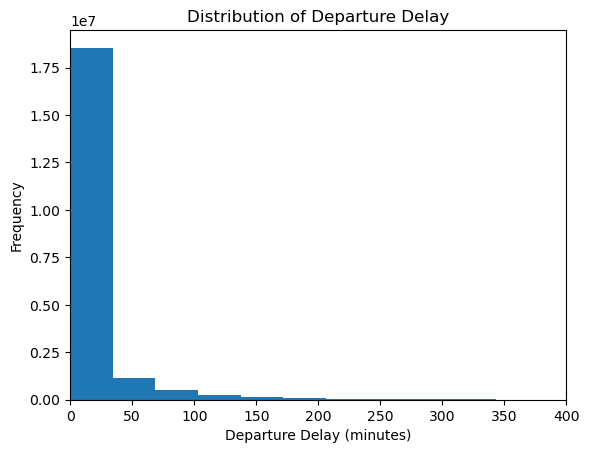

In [ ]:
# Distribution of departure delay
plt.hist(flights['DEP_DELAY_NEW'], bins=100)
plt.xlim(0,400)
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Departure Delay')
plt.show()

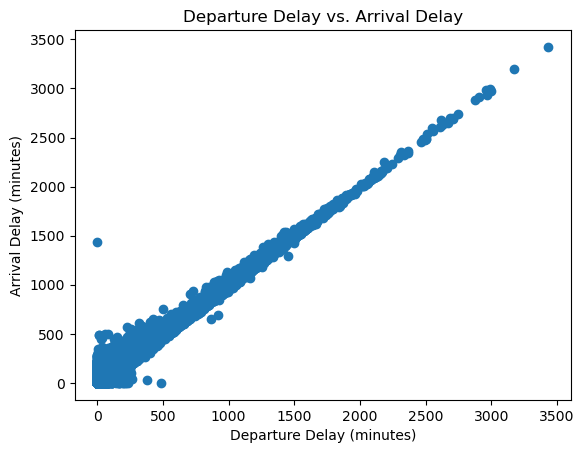

In [ ]:
plt.scatter(flights['DEP_DELAY_NEW'], flights['ARR_DELAY_NEW'])
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Arrival Delay (minutes)')
plt.title('Departure Delay vs. Arrival Delay')
plt.show()

In [ ]:
avg_dep_delay_by_city = flights.groupby('ORIGIN_CITY_NAME')['DEP_DELAY_NEW'].mean()

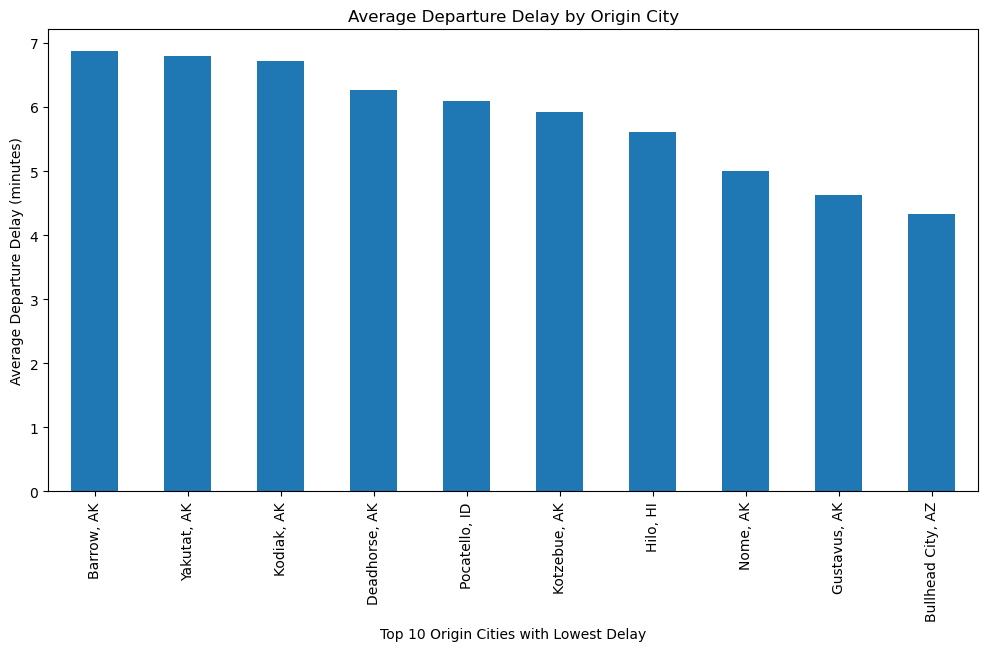

In [ ]:
plt.figure(figsize=(12, 6))
avg_dep_delay_by_city.sort_values(ascending=False)[-10:].plot(kind='bar')
plt.xlabel('Top 10 Origin Cities with Lowest Delay')
plt.ylabel('Average Departure Delay (minutes)')
plt.title('Average Departure Delay by Origin City')
plt.show()

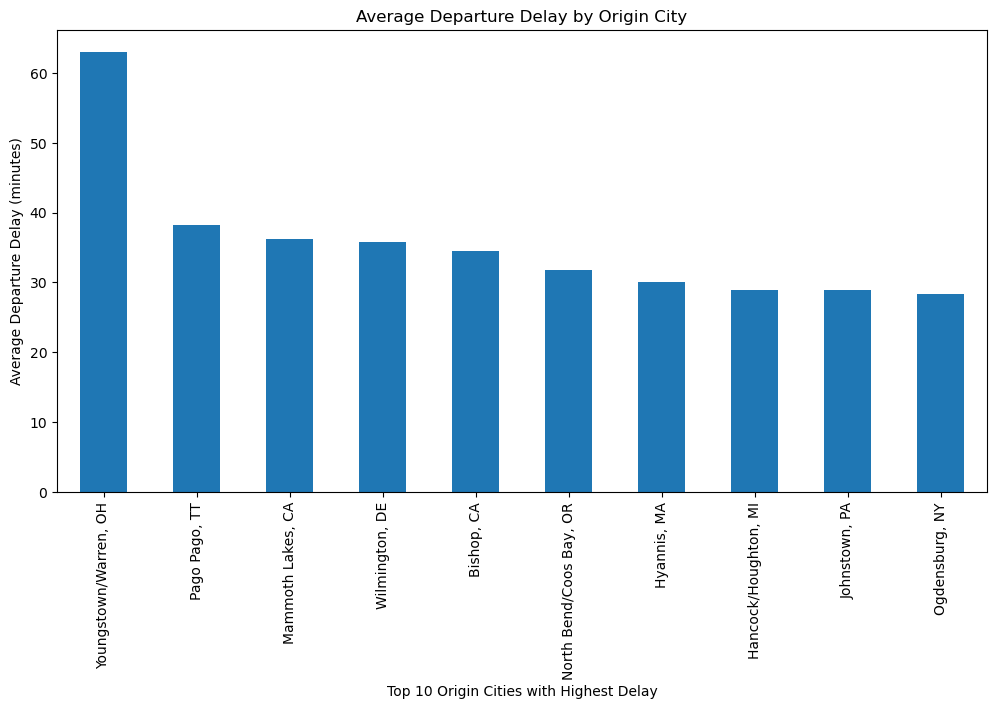

In [ ]:
plt.figure(figsize=(12, 6))
avg_dep_delay_by_city.sort_values(ascending=False)[0:10].plot(kind='bar')
plt.xlabel('Top 10 Origin Cities with Highest Delay')
plt.ylabel('Average Departure Delay (minutes)')
plt.title('Average Departure Delay by Origin City')
plt.show()

In [ ]:
correlation = flights[['TOTAL_DELAY', 'DISTANCE']].corr()
print(correlation)

             TOTAL_DELAY  DISTANCE
TOTAL_DELAY     1.000000  0.008457
DISTANCE        0.008457  1.000000


# Time series analysis - Total delay over time

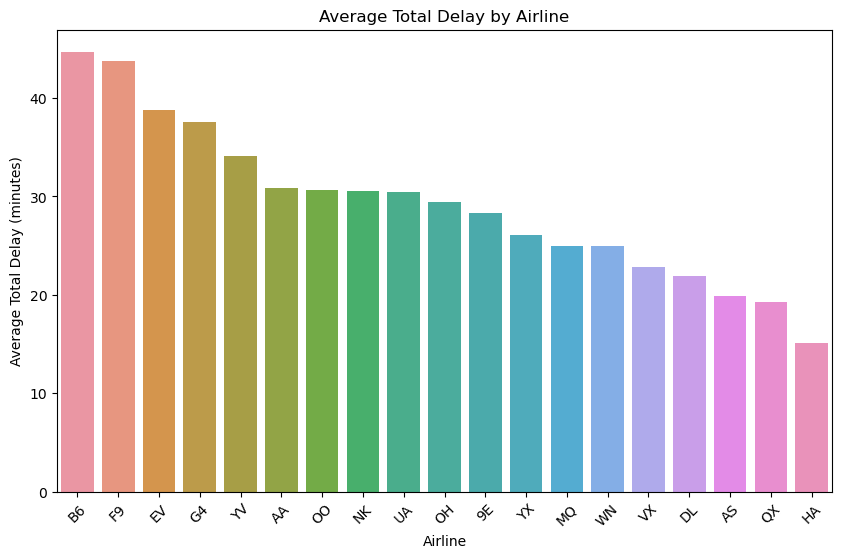

In [ ]:
# Comparison analysis - Average total delay by airline
avg_delay_by_airline = flights.groupby('OP_UNIQUE_CARRIER')['TOTAL_DELAY'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_delay_by_airline.index, y=avg_delay_by_airline.values)
plt.xlabel('Airline')
plt.ylabel('Average Total Delay (minutes)')
plt.title('Average Total Delay by Airline')
plt.xticks(rotation=45)
plt.show()

# Scatter plot - Delay vs. distance

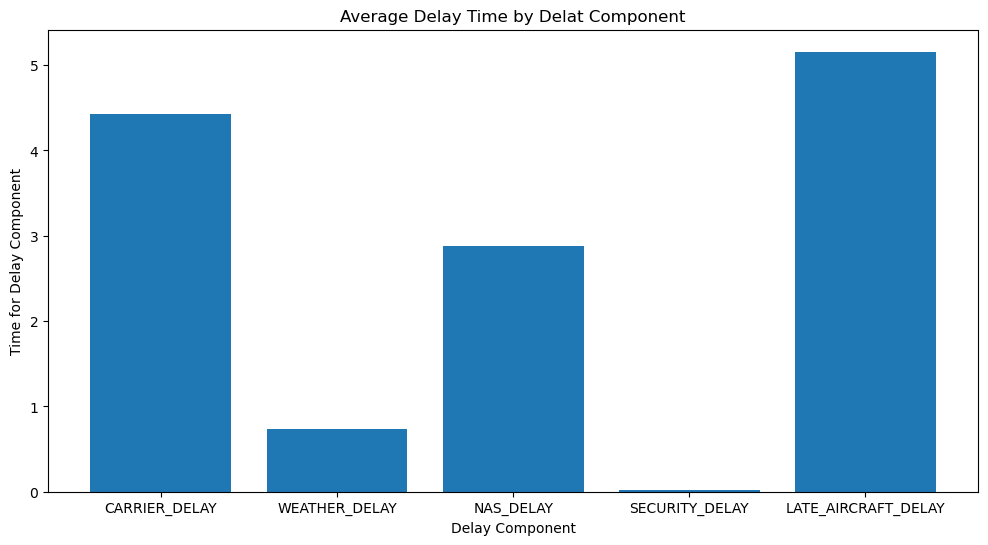

In [ ]:
# Stacked bar plot - Delay components
delay_components = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
delay_sums = flights[delay_components].sum()
delay_components_times = []
for component in delay_components:
    delay_components_times.append(flights[component].mean())

plt.figure(figsize=(12, 6))
plt.bar(delay_components, delay_components_times)
plt.xlabel('Delay Component')
plt.ylabel('Time for Delay Component')
plt.title('Average Delay Time by Delat Component')
plt.show()

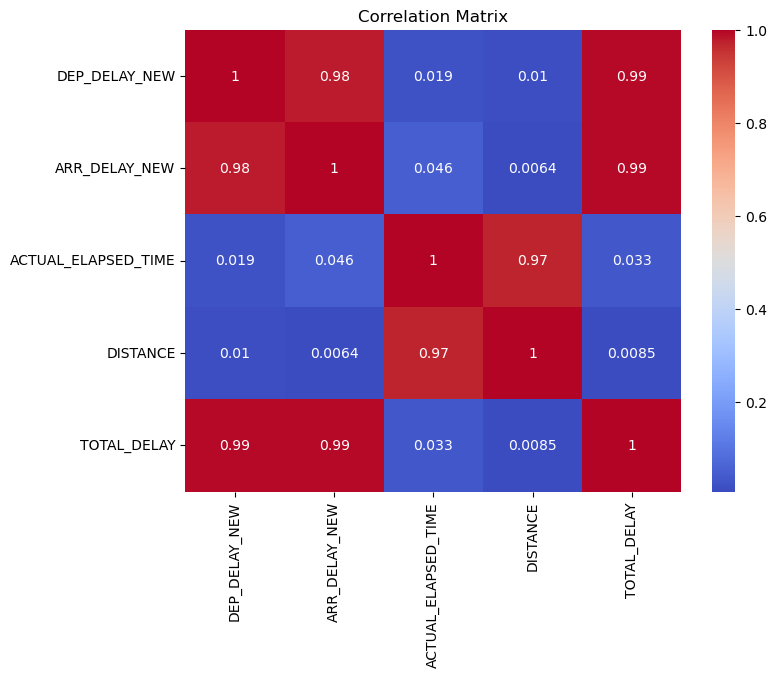

In [ ]:
# Heatmap - Correlation matrix
correlation_matrix = flights[['DEP_DELAY_NEW', 'ARR_DELAY_NEW', 'ACTUAL_ELAPSED_TIME', 'DISTANCE', 'TOTAL_DELAY']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Model Selection/Estimation

In [ ]:
X = encoded_data.drop(columns=["DELAY_STATUS"])
y = encoded_data['DELAY_STATUS']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)


/Users/atomar/opt/anaconda3/envs/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/atomar/opt/anaconda3/envs/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/atomar/opt/anaconda3/envs/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/atomar/opt/anaconda3/envs/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/atomar/opt/anaconda3/envs/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/atomar/opt/anacond

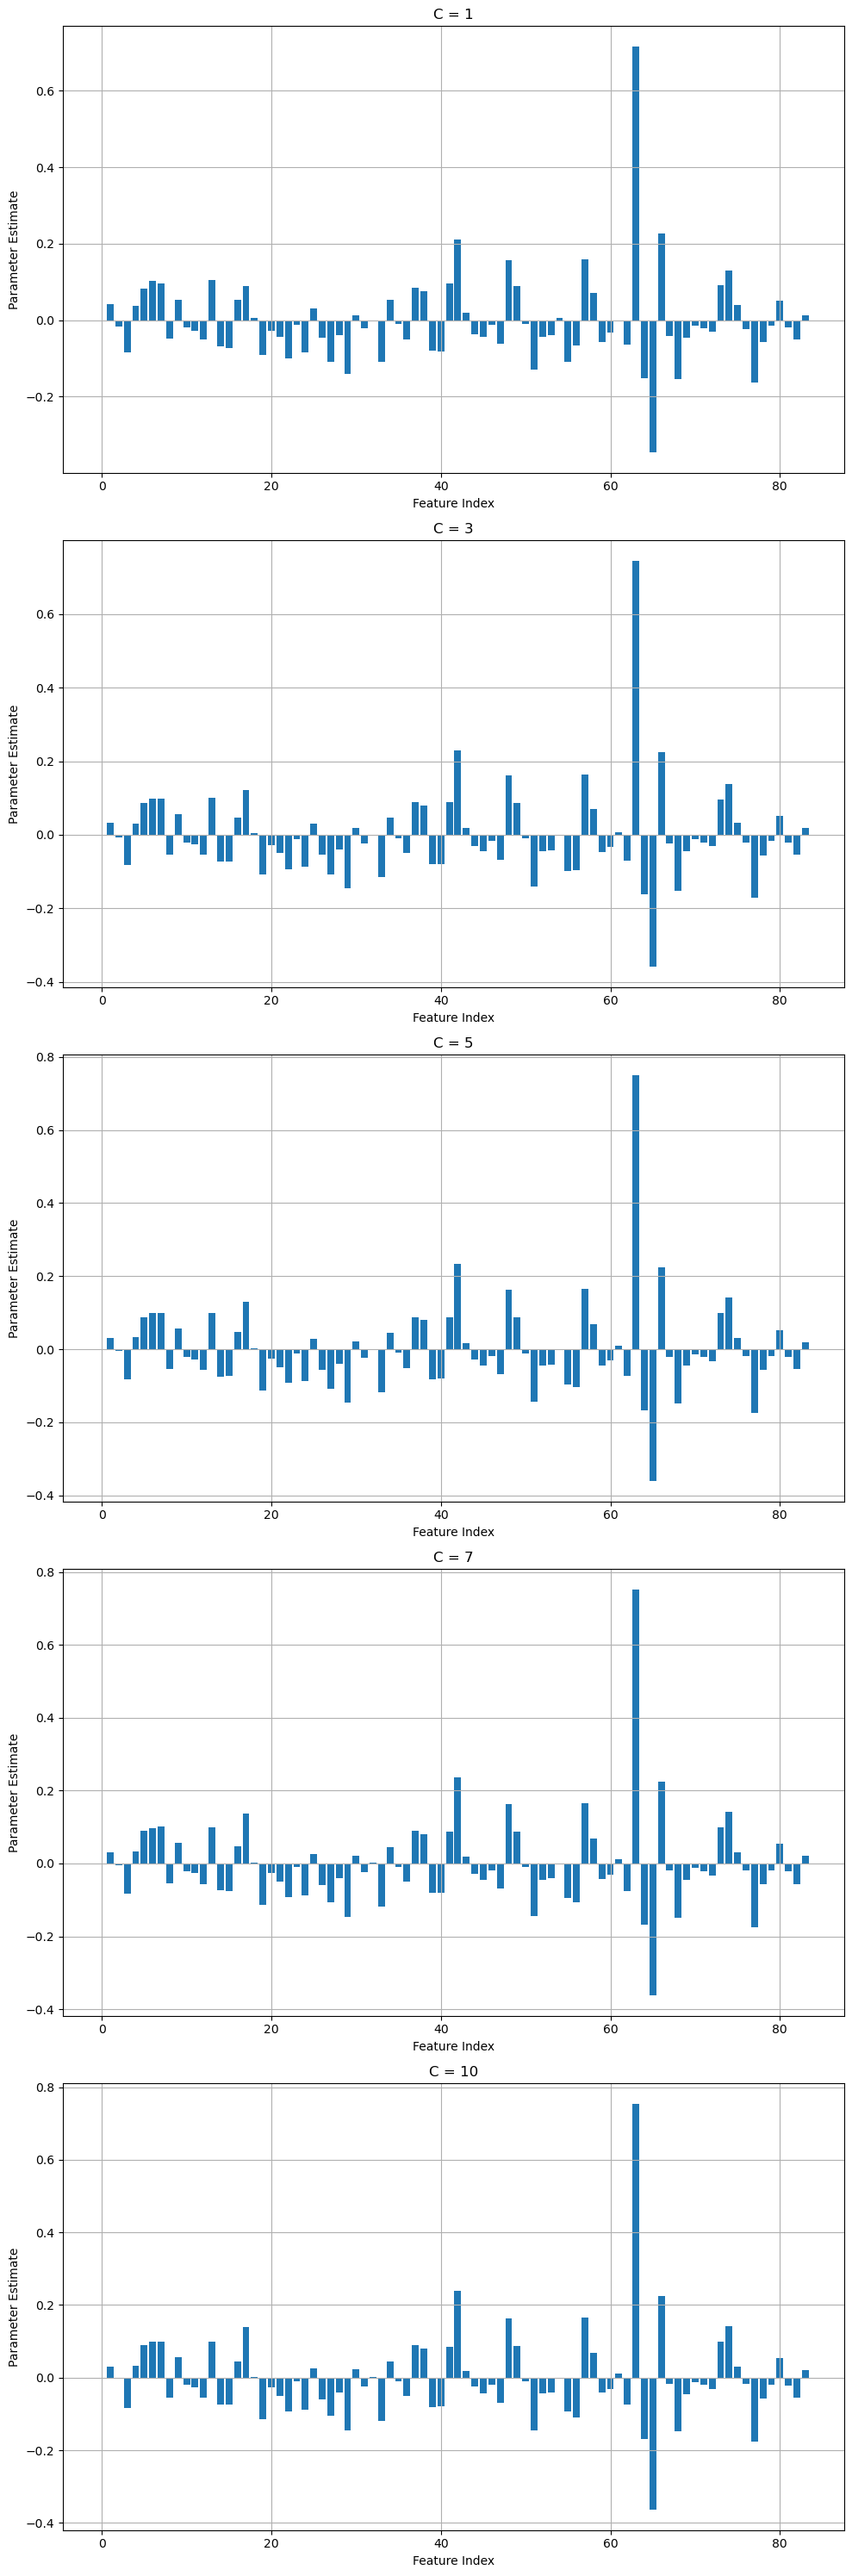

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
import numpy as np
import matplotlib.pyplot as plt

c_values = [1, 3, 5, 7, 10]
coefs_list = []
accuracies = []

# Fit the models separately and save the coefficient estimates to a list
for c in c_values:
    svm_model = LinearSVC(C=c, max_iter = 20000)
    cv_scores = cross_validate(svm_model, X, y, cv=5, return_estimator=True)
    estimators = cv_scores['estimator']
    mean_score = cv_scores['test_score'].mean()


    coefs = [estimator.coef_[0] for estimator in estimators]
    avg_coefs = np.mean(coefs, axis=0)
    
    coefs_list.append(avg_coefs)
    accuracies.append(mean_score)


# Create separate plots for each C value
num_features = len(coefs_list[0])
num_c_values = len(c_values)
fig, axes = plt.subplots(num_c_values, 1, figsize=(10, 6*num_c_values))

# Plot the bar plots for each C value
for i, ax in enumerate(axes):
    coefs = coefs_list[i]
    ax.bar(range(num_features), coefs)
    ax.set_xlabel('Feature Index')
    ax.set_ylabel('Parameter Estimate')
    ax.set_title(f'C = {c_values[i]}')
    ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
print("Top 10 Features With the Biggest Parameter Estimates For Each C Value(greatest to least): \n")
for i in range(len(coefs_list)):
    coefs = coefs_list[i]
    top_ten_indices = np.argsort(coefs)[-10:]
    top_ten_indices = np.flip(top_ten_indices)
    top_ten_features = [list(X.columns)[i] for i in top_ten_indices]
    
    print("C = " + str(c_values[i]) + ": \n" + str(top_ten_features))



Top 10 Features With the Biggest Parameter Estimates For Each C Value(greatest to least): 

C = 1: 
['Carrier_QX', 'Carrier_WN', 'DestCity_Newark, NJ', 'Carrier_F9', 'DestCity_San Francisco, CA', 'Month_6', 'OriginCity_Miami, FL', 'OriginCity_Dallas/Fort Worth, TX', 'OriginCity_Denver, CO', 'DestCity_New York, NY']
C = 3: 
['Carrier_QX', 'DestCity_Newark, NJ', 'Carrier_WN', 'Carrier_F9', 'DestCity_San Francisco, CA', 'Month_6', 'OriginCity_Newark, NJ', 'OriginCity_Miami, FL', 'OriginCity_Dallas/Fort Worth, TX', 'OriginCity_Denver, CO']
C = 5: 
['Carrier_QX', 'DestCity_Newark, NJ', 'Carrier_WN', 'Carrier_F9', 'DestCity_San Francisco, CA', 'Month_6', 'OriginCity_Newark, NJ', 'OriginCity_Denver, CO', 'OriginCity_Miami, FL', 'OriginCity_Dallas/Fort Worth, TX']
C = 7: 
['Carrier_QX', 'DestCity_Newark, NJ', 'Carrier_WN', 'Carrier_F9', 'DestCity_San Francisco, CA', 'Month_6', 'OriginCity_Newark, NJ', 'OriginCity_Denver, CO', 'OriginCity_Miami, FL', 'Month_5']
C = 10: 
['Carrier_QX', 'DestCity

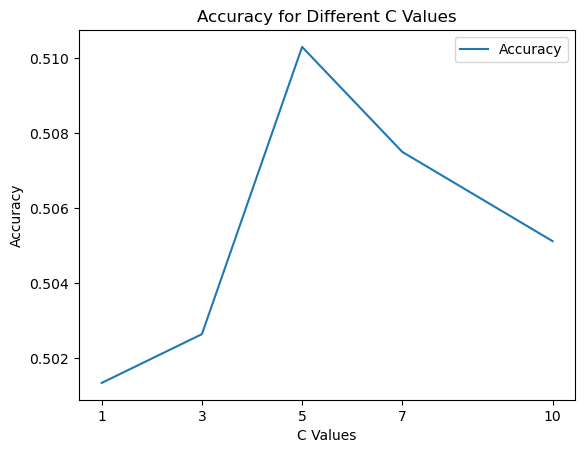

In [ ]:
# Plot the progression of C values against accuracy
plt.plot(c_values, accuracies, label='Accuracy')
plt.xlabel('C Values')
plt.xticks(c_values)
plt.ylabel('Accuracy')
plt.title('Accuracy for Different C Values')

plt.legend()

In [ ]:
print(c_values)
print(accuracies)

[1, 3, 5, 7, 10]
[0.50134, 0.5026400000000001, 0.5103, 0.5075000000000001, 0.50512]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Create a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=500, n_jobs = -1, random_state=42, min_samples_split = 100, min_samples_leaf = 100)


# Train the Random Forest model
rf_model.fit(X_train, y_train)


# Make predictions on the test set
y_pred = rf_model.predict(X_test)


# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5662


In [ ]:

from sklearn.linear_model import LogisticRegression


# Create and fit a logistic regression model
logreg_model = LogisticRegression(C = 1,max_iter=20000)
logreg_model.fit(X_train, y_train)


# Predict on the test set
y_pred = logreg_model.predict(X_test)




from sklearn.metrics import precision_score, recall_score, f1_score
# Convert label values in y_test to integers
y_test2 = y_test.astype(int)


# Convert y_pred to match the format of y_test
y_pred2 = y_pred.astype(int)


# Calculate precision
precision = precision_score(y_test2, y_pred2, pos_label=1)


# Calculate recall
recall = recall_score(y_test2, y_pred2, pos_label=1)


# Calculate F1 score
f1 = f1_score(y_test2, y_pred2)

accuracy = accuracy_score(y_test2, y_pred2)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)


Accuracy: 0.5584
Precision: 0.5598339866267005
Recall: 0.49199594731509627
F1 score: 0.5237273511647972
